In [90]:
import numpy as np
from matplotlib import pyplot as plt
import re
%matplotlib notebook

In [22]:
def readInFile(filename, airports=False):
    results = {}
    with open(filename) as f:
        for line in f:
            line = line.replace("(", "")
            line = line.replace(")", "")
            lineStats = line.strip().split(",")
            if airports:
                results[lineStats[0]] = generatePercentileString(lineStats[2:])
            else:
                results[lineStats[0]] = generatePercentileString(lineStats[1:])
    if airports:
        return results
    
    sortedResults = {}
    for k, v in sorted( results.items() ):
        sortedResults[k] = v
        
    monthResults = {}
    for k, v in sortedResults.items():
        month = k[5:7]
        if month not in monthResults:
            monthResults[month] = {}
        monthResults[month][k] = v

    return monthResults

In [39]:
def generatePercentileString(lineStats):
    minV = float( lineStats[0] )
    maxV = float( lineStats[1] )
    median = float( lineStats[2] )
    Q1 = float( lineStats[3] )
    Q3 = float( lineStats[4] )
    avg = float( lineStats[5] )
    count = int( lineStats[6] )
    
    threshold = float( lineStats[7] )
    if threshold < maxV:
        maxV = threshold
        
    outliers = lineStats[8].split(" ")
    if outliers[0] is '':
        outliers = None
    else:
        outliers = list(map(float, outliers))
        
    return [ [minV, Q1, median, Q3, maxV, outliers], avg, count ]

def getPercentiles(stats):
    percentiles = {}
    for month, days in stats.items():
        percentiles[month] = []
        for date, stats in days.items():
            percentiles[month].append(stats[0])
    return percentiles

def getPerecentilesAirport(stats):
    percentiles = []
    labels = []
    for airport, values in stats.items():
        labels.append(airport)
        percentiles.append(values[0])
    return percentiles, labels

In [4]:
def customized_box_plot(percentiles, axes, redraw = True, *args, **kwargs):
    """
    Generates a customized boxplot based on the given percentile values
    https://stackoverflow.com/questions/27214537/
    is-it-possible-to-draw-a-matplotlib-boxplot-given-the-percentile-values-instead
    """
    n_box = len(percentiles)
    box_plot = axes.boxplot([[-9, -4, 2, 4, 9],]*n_box, *args, **kwargs) 
    # Creates len(percentiles) no of box plots

    min_y, max_y = float('inf'), -float('inf')

    for box_no, (q1_start, 
                 q2_start,
                 q3_start,
                 q4_start,
                 q4_end,
                 fliers_xy) in enumerate(percentiles):

        # Lower cap
        box_plot['caps'][2*box_no].set_ydata([q1_start, q1_start])
        # xdata is determined by the width of the box plot

        # Lower whiskers
        box_plot['whiskers'][2*box_no].set_ydata([q1_start, q2_start])

        # Higher cap
        box_plot['caps'][2*box_no + 1].set_ydata([q4_end, q4_end])

        # Higher whiskers
        box_plot['whiskers'][2*box_no + 1].set_ydata([q4_start, q4_end])

        # Box
        box_plot['boxes'][box_no].set_ydata([q2_start, 
                                             q2_start, 
                                             q4_start,
                                             q4_start,
                                             q2_start])

        # Median
        box_plot['medians'][box_no].set_ydata([q3_start, q3_start])
        
        #Convert fliers to proper format
        if fliers_xy is not None:
            fliers_x = np.array( [box_no +1 for _ in fliers_xy] )
            fliers_xy = [fliers_x, np.array( fliers_xy )]
        
        # Outliers
        if fliers_xy is not None and len(fliers_xy[0]) != 0:
            # If outliers exist
            box_plot['fliers'][box_no].set(xdata = fliers_xy[0],
                                           ydata = fliers_xy[1])

            min_y = min(q1_start, min_y, fliers_xy[1].min())
            max_y = max(q4_end, max_y, fliers_xy[1].max())

        else:
            min_y = min(q1_start, min_y)
            max_y = max(q4_end, max_y)

        # The y axis is rescaled to fit the new box plot completely with 10% 
        # of the maximum value at both ends
        axes.set_ylim([min_y*1.1, max_y*1.1])

    # If redraw is set to true, the canvas is updated.
    if redraw:
        axes.figure.canvas.draw()

    return box_plot

In [62]:
def plotMonth(filename, month):
    stats = readInFile(filename)
    percentiles = getPercentiles(stats)
    fig, ax = plt.subplots()
    b = customized_box_plot(percentiles[month], ax, redraw=True, notch=0, sym='+', vert=1, whis=1.5)
    ax.set_title(month + " 2018 Delay Times From Denver to Chicago")
    ax.tick_params(axis='x', pad=0.5, labelsize='small', labelrotation=30)
    ax.set_ylabel("Minutes Delayed")
    ax.set_xlabel("Date")
    ax.grid()

    plt.savefig("AtoBYear" + month + ".png")

def plotYear(filename, setMax=False):
    stats = readInFile(filename)
    percentiles = getPercentiles(stats)
    
    fig, axes = plt.subplots(4, 3, figsize=(25,25))
    fig.suptitle("2018 Delay Times From Denver to Chicago", fontsize=24)
    fig.subplots_adjust(top=0.95)
    months = list( percentiles.keys() )
    i = 0
    
    for axRow in axes:
        for ax in axRow:
            b = customized_box_plot(percentiles[months[i]], ax, redraw=True, notch=0, sym='+', vert=1, whis=1.5)
            ax.set_title("Month: {}".format(months[i]))
            if setMax:
                ax.set_ylim([0, 1100])
            ax.tick_params(axis='x', pad=0.5, labelsize='small', labelrotation=30)
            ax.grid()
            i += 1

    plt.savefig("AtoBYear.png")

def plotAirports(filename):
    stats = readInFile(filename, True)
    percentiles, labels = getPerecentilesAirport(stats)
    fig, ax = plt.subplots(figsize=(10,10))
    b = customized_box_plot(percentiles, ax, redraw=True, notch=0, sym='+', vert=1, whis=1.5)
    ax.set_title(" [ADD DATE] Delay Times From Denver to Top 25 Cities", fontsize=20)
    ax.set_xticklabels(labels)
    ax.tick_params(axis='x', pad=0.5, labelsize='large', labelrotation=90)

    ax.set_ylabel("Minutes Delayed", fontsize=15)
    ax.set_xlabel("City", fontsize=15)
    ax.grid()
    plt.tight_layout()
    plt.savefig("top25Cites.png")

In [71]:
def writeCSVforGeoMaps(filename):
    stats = readInFile(filename, True)
    with open("geomap.csv", 'w') as f:
        f.write("City,Average Delay\n")
        for city, v in stats.items():
            f.write(city + "," + str(v[1]) + '\n')

In [72]:
writeCSVforGeoMaps("cool.txt")

In [143]:
def readAverageData(filename):
    # Date: predicted with zero, predicted no zero, actual with zero, actual with no zero
    results = {}
    
    with open(filename) as f:
        for line in f:
            line = re.sub("[()\\[\\]List]", "", line).strip().split(',')
            line = [l.strip() for l in line]
            results[line[1]] = list(map(float, [line[5], line[6], line[11], line[12]] ))
    return results


def calcAverageRMSE(averageData):
    rmseZero = 0
    rmseNoZero = 0
    n = len(averageData)
    for date, values in averageData.items():
        rmseZero += ( (values[0] - values[2])**2 / n)
        rmseNoZero += ( (values[1] - values[3])**2 / n)
    rmseZero = rmseZero**.5
    rmseNoZero = rmseNoZero**.5
    print("RMSE With Zeroes: {:.6f}".format(rmseZero))
    print("RMSE Without Zeroes: {:.6f}".format(rmseNoZero))
    return (rmseZero, rmseNoZero)

def plotAverageResults(averageData, zero=False):
    actualZero, predictZero, actualNoZero, predictNoZero = [], [], [], []
    dates = []
    for date, values in averageData.items():
        dates.append(date)
        predictZero.append(values[0])
        predictNoZero.append(values[1])
        actualZero.append(values[2])
        actualNoZero.append(values[3])
        
    plt.figure(figsize=(18,10))
    
    if zero:
        plt.plot(predictZero, '-o', label="Predicted Delay")
        plt.plot(actualZero, '-o', label="Actual Delay")
    else:
        plt.plot(predictNoZero, '-o', label="Predicted Delay")
        plt.plot(actualNoZero, '-o', label="Actual Delay")
    plt.grid()
    plt.legend(fontsize=27)
    plt.xlabel("Date", fontsize=25)
    plt.ylabel("Minutes Delayed", fontsize=25)
    plt.title("Flight Delay Prediction for 2019 from Denver", fontsize=30)
    plt.xticks(range(len(dates)), dates, rotation=45, horizontalalignment='right')
    plt.tick_params(axis='y', which='major', labelsize=18)
    plt.tick_params(axis='x', which='major', labelsize=13)
    plt.savefig("average.png", bbox_inches='tight')

RMSE With Zeroes: 12.071699
RMSE Without Zeroes: 17.233296


<IPython.core.display.Javascript object>


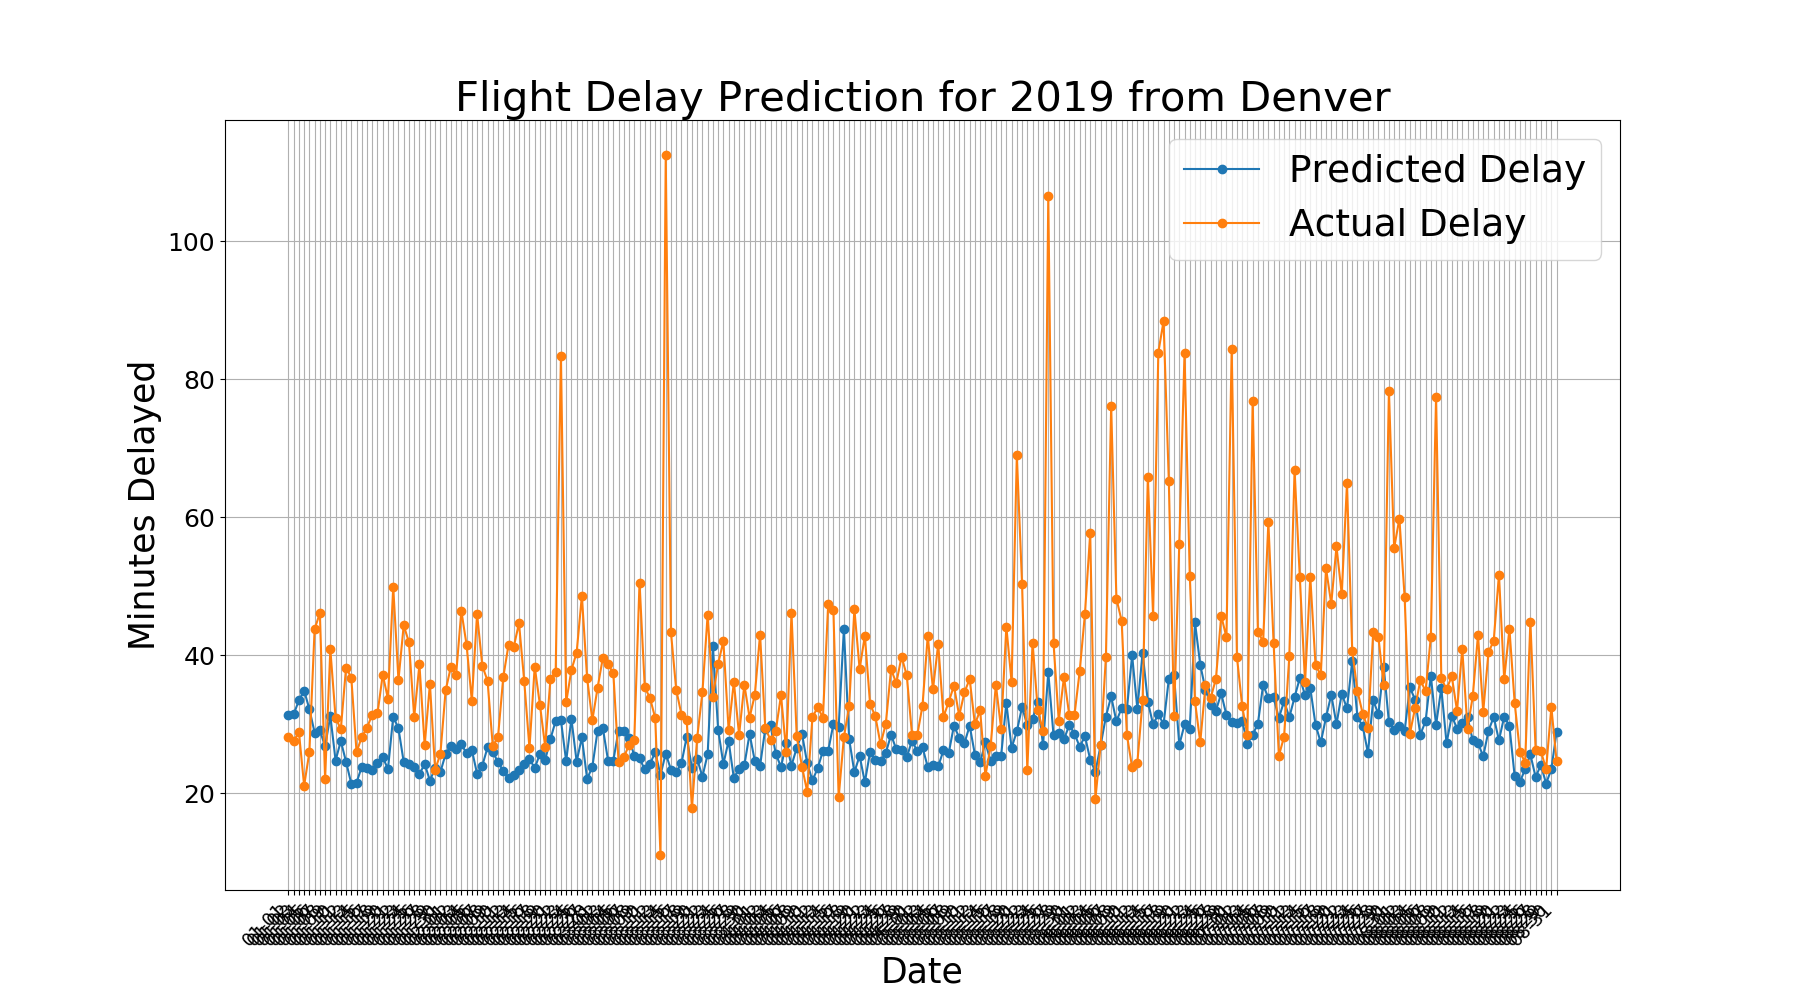

In [146]:
av = readAverageData("caleb.txt")
calcAverageRMSE(av)
plotAverageResults(av, zero=False)

In [137]:
av

{'01-01': [20.006118375757826,
  31.388055932912447,
  19.2960413080895,
  28.239294710327457],
 '01-02': [20.362954674357898,
  31.458432863858224,
  15.320930232558139,
  27.526462395543174],
 '01-03': [22.214510746553977,
  33.461294649802696,
  11.693944353518821,
  28.927125506072876],
 '01-04': [25.950369846893132,
  34.90439794270838,
  6.335925349922239,
  21.10880829015544],
 '01-05': [21.855147706347335,
  32.19836053540716,
  8.297445255474452,
  25.982857142857142],
 '01-06': [17.13879466812163,
  28.819451702342622,
  17.76121794871795,
  43.80632411067194],
 '01-07': [16.701934217424093,
  29.145783042748825,
  21.36215334420881,
  46.109154929577464],
 '01-08': [13.95724346723804,
  26.809730309237505,
  4.256323777403035,
  22.140350877192983],
 '01-09': [18.37646204223069,
  31.248693488292428,
  7.601340033500837,
  40.88288288288288],
 '01-10': [11.740202215275755,
  24.75827791260915,
  6.225700164744646,
  30.975409836065573],
 '01-11': [14.693453058851151,
  27.58

In [120]:
def readLinearData(filename):
    y, x = [], []
    with open(filename) as f:
        for line in f:
            line = re.sub("[()\\[\\]]", "", line).strip()
            lineStats = list(map(float, line.strip().split(",") ))
            y.append(lineStats[0])
            x.append(lineStats[1])
        
    return y, x

def plotLinearData(filename, slope, date):
    y, x = readLinearData(filename)

    def f(x):
        return (x) *  slope

    x_lin = np.linspace(min(x), max(x))

    plt.plot(x,y, '.', label='Actual Delay Times')
    plt.plot(x_lin, f(x_lin), label='Linear Prediction Line')
    plt.grid()
    plt.ylim(0,300)
    plt.legend()
    plt.title("Estimated Delay Time from Denver on " + date)
    plt.ylabel("Minutes Delayed")
    plt.xlabel("Year")
    plt.savefig("linear.png")

<IPython.core.display.Javascript object>


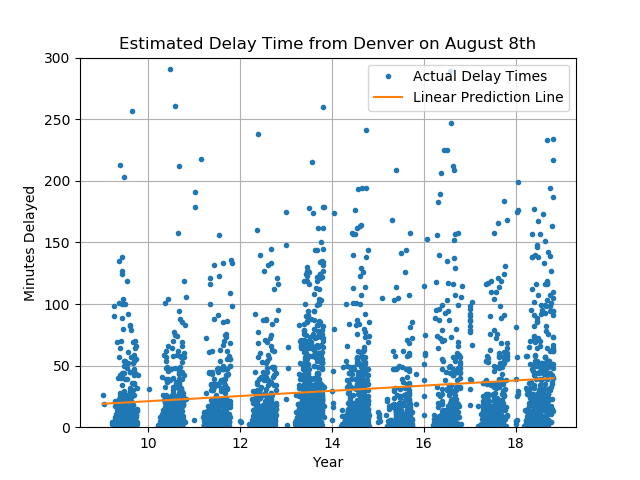

In [129]:
SLOPE = 2.1089334456770654
plotLinearData("yoi.txt", SLOPE, "August 8th")

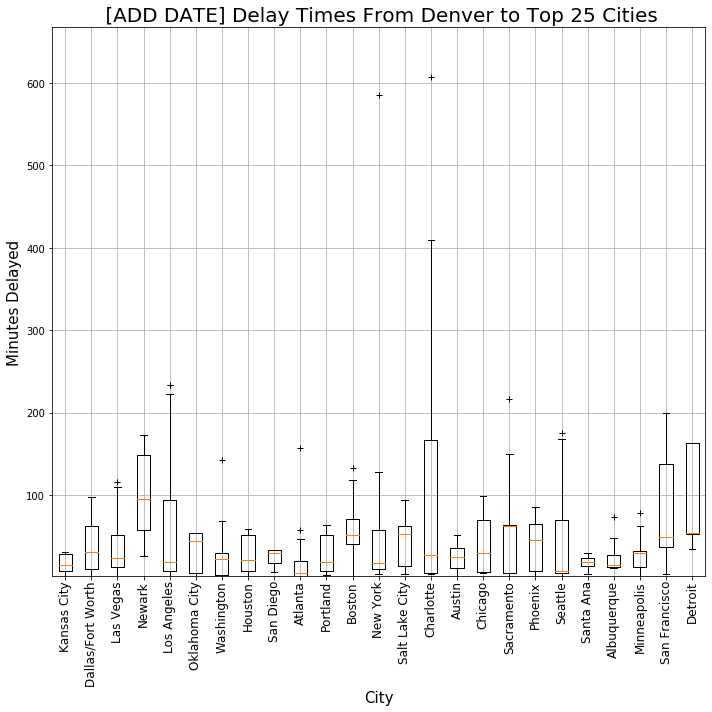

In [63]:
plotAirports("withoutAirport.txt")

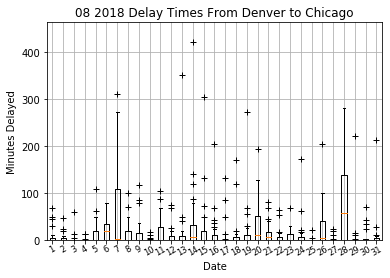

In [10]:
plotMonth("with2.txt", '08')

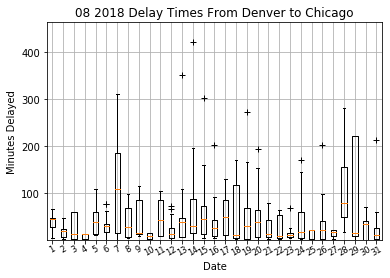

In [11]:
plotMonth("without2.txt", '08')